In [ ]:
! pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=d5e920e9af77814f32468c81ab0d90b387d3c89f9d38dc5340fd8270a0bf28b4
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Convert Excel format to CSV format.

In [ ]:
#excel_path = '/Users/shalu/Downloads/forecasting_case_study.xlsx - Sheet1.csv'
#csv_output_path = '/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv'

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv')

#df.to_csv(csv_output_path, index=False)

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("ReadDataExample").getOrCreate()

Read csv.

In [ ]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [ ]:
df.show(5)

+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017|27750|                0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017|29023|                0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017|45630|               17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017|26789|                0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SK

In [ ]:
display( df )

DataFrame[Product: string, date: string, Sales: int, Price Discount (%): string, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int]

Check if there are missing values.

In [ ]:
from pyspark.sql.functions import col, isnan, when, count

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType != 'date'])
missing_counts.show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      0|   0|    0|                 0|             0|              0|              0|              0|         0|    0|     0|        0|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+



**Observation**  
No missng values existing

In [ ]:
df.count(), len(df.columns)

(1218, 12)

**Observation**  
1218 observations and 12 columns.

In [ ]:
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- date: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: integer (nullable = true)
 |-- Catalogue Promo: integer (nullable = true)
 |-- Store End Promo: integer (nullable = true)
 |-- Google_Mobility: double (nullable = true)
 |-- Covid_Flag: integer (nullable = true)
 |-- V_DAY: integer (nullable = true)
 |-- EASTER: integer (nullable = true)
 |-- CHRISTMAS: integer (nullable = true)



**Observation**   
PySpark does not support "categorical" data type. So, we don't convert the data type for "In-Store Promo", "Catalogue Promo", "Store End Promo", "Covid_Flag", "V_DAY", "EASTER", and "CHRISTMAS".  In general, PySpark uses "string" and "integer" for "categorical" values.  

In [ ]:
df.select("Sales", "Google_Mobility")

DataFrame[Sales: int, Google_Mobility: double]

Validate the name of columns. Put _ between word in stead of space.

In [ ]:
df = (
    df
    .withColumnRenamed("Price Discount (%)", "Price_Discount_(%)")
    .withColumnRenamed("In-Store Promo", "In-Store_Promo")
    .withColumnRenamed("Catalogue Promo", "Catalogue_Promo")
    .withColumnRenamed("Store End Promo", "Store_End_Promo")
)

In [ ]:
df.show(5)

+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|     date|Sales|Price_Discount_(%)|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+---------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1| 2/5/2017|27750|                0%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/12/2017|29023|                0%|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2/19/2017|45630|               17%|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2/26/2017|26789|                0%|             1|              0|              1|            0.0|         0|    0|     0|        0|
|   SK

In [ ]:
duplicates = df.groupBy("Product").count().filter(col("count") > 1)
duplicates.show()

+-------+-----+
|Product|count|
+-------+-----+
|   SKU3|  204|
|   SKU4|  204|
|   SKU1|  204|
|   SKU5|  204|
|   SKU6|  198|
|   SKU2|  204|
+-------+-----+



**Observation**  
6products

In [ ]:
description = df.describe()
description.show()

+-------+-------+---------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|summary|Product|     date|             Sales|Price_Discount_(%)|    In-Store_Promo|    Catalogue_Promo|    Store_End_Promo|    Google_Mobility|         Covid_Flag|               V_DAY|              EASTER|           CHRISTMAS|
+-------+-------+---------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|  count|   1218|     1218|              1218|              1218|              1218|               1218|               1218|               1218|               1218|                1218|                1218|                1218|
|   mean|   null|     null|30294.678981937603|              null|0.4720853858784893|0.21

In [ ]:
df.describe().toPandas()

,summary,Product,date,Sales,Price_Discount_(%),In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,count,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
1,mean,None,None,30294.678981937603,None,0.4720853858784893,0.21264367816091953,0.34893267651888343,-2.3774055829228224,0.22660098522167488,0.019704433497536946,0.019704433497536946,0.018883415435139574
2,stddev,None,None,35032.5272965258,None,0.4994252268419534,0.40934571855807333,0.47682841234861867,5.806290981009834,0.4188042296935616,0.13903970926580328,0.13903970926580325,0.13616921612117958
3,min,SKU1,1/12/2020,0,0%,0,0,0,-28.49,0,0,0,0
4,max,SKU6,9/9/2018,288322,9%,1,1,1,3.9,1,1,1,1


PySpark is not good at Visualization. So, we convert it to pandas format to plot graphs.

In [ ]:
pandas_df = df.toPandas()

In [ ]:
pandas_df.describe(include= ['object']).T

,count,unique,top,freq
Product,1218,6,SKU1,204
date,1218,204,2/5/2017,6
Price_Discount_(%),1218,70,0%,231


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

In [ ]:
df.head()

Row(Product='SKU1', date='2/5/2017', Sales=27750, Price_Discount_(%)='0%', In-Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility=0.0, Covid_Flag=0, V_DAY=0, EASTER=0, CHRISTMAS=0)

<Axes: xlabel='date', ylabel='Sales'>

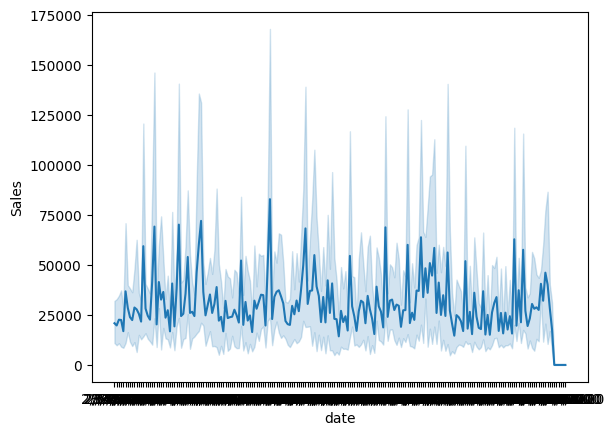

In [ ]:
sns.lineplot(x = 'date', y = 'Sales', data=pandas_df)

In [ ]:
df=spark.read.option("header",True) \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/forecasting_case_study.csv")

In [ ]:
df.write.option("header", True) \
        .partitionBy("Product") \
        .mode("overwrite") \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [ ]:
dfSinglePart=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU1")

In [ ]:
def histplot_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined

    feature: 1-d feature array

    figsize: size of fig (default (9, 8))

    bins: number of bins (default None / auto)

    """
    f2, (ax_box2, ax_his2) = plt.subplots(nrows=2,  # Number of rows of the subplot grid = 2
                                           sharex=True,  # X-axis will be shared among all subplots
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize
                                           )  # Creating the 2 subplots

    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet')  # Boxplot will be created and a symbol will indicate the mean value of the column

    if bins:
        sns.histplot(x=feature, kde=True, ax=ax_his2, bins=bins, palette="winter")  # For histogram
    else:
        sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram

    ax_his2.axvline(np.mean(feature), color='green', linestyle='--')  # Add mean to the histogram

    ax_his2.axvline(np.median(feature), color='black', linestyle='-')  # Add median to the histogram


In [ ]:
dfSinglePart.printSchema()
dfSinglePart.show()
df1= dfSinglePart.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+---------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|     date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+---------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
| 2/5/2017| 27750|                0%|             0|              0|              0|              0|         0|    0|    

In [ ]:
df1['Price Discount (%)']= df1['Price Discount (%)'].str[:-1]
df1['Price Discount (%)']= df1['Price Discount (%)'].astype(int)

In [ ]:
df1.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [ ]:

cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df1[cols]=df1[cols].apply(pd.to_numeric)
df1['date']=df1['date'].apply(pd.to_datetime)
df1=df1[df1['Sales'] !=0]

In [ ]:
df1.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
193,2020-10-18,43976,17,1,0,0,-7.56,1,0,0,0
194,2020-10-25,49593,17,0,0,0,-8.39,1,0,0,0
195,2020-11-01,33267,1,1,0,1,-7.43,1,0,0,0
196,2020-11-08,50159,17,1,0,1,-5.95,1,0,0,0
197,2020-11-15,51369,17,1,0,1,-7.20,1,0,0,0


<ipython-input-32-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


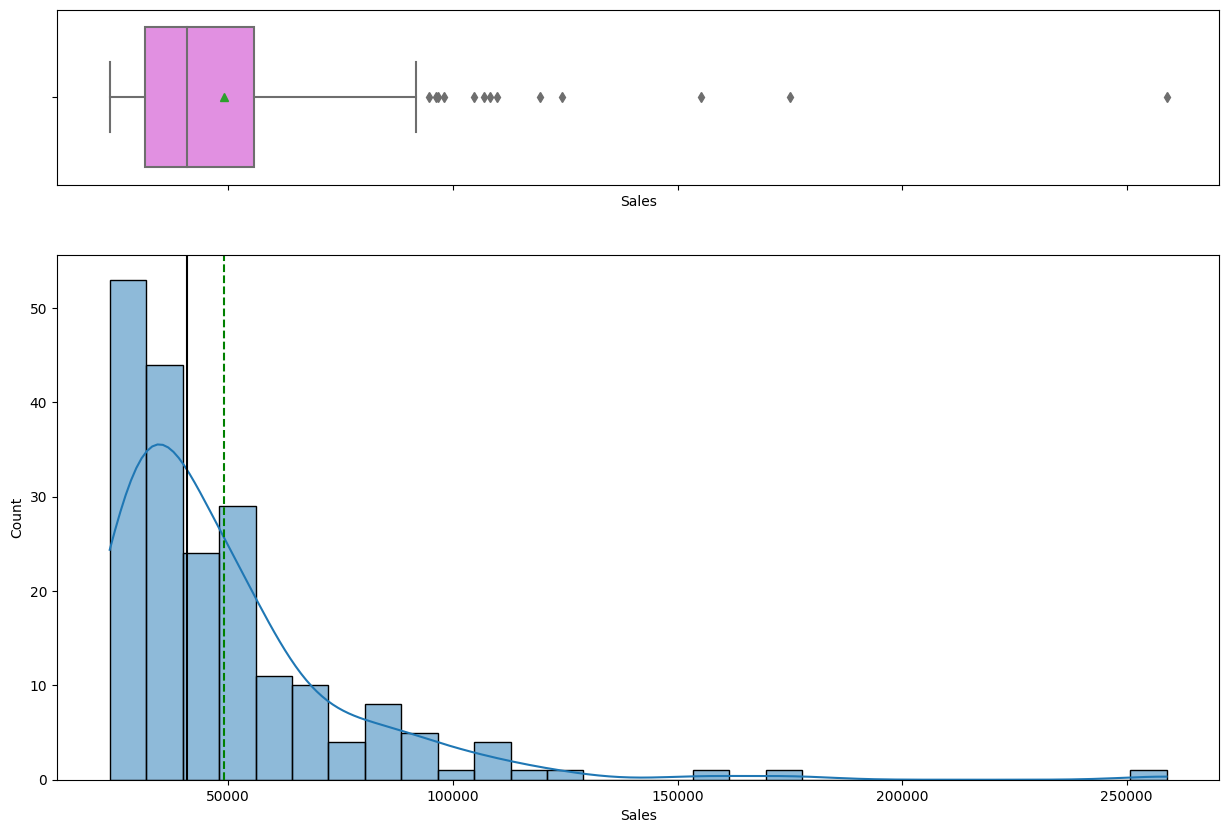

In [ ]:
histplot_boxplot(df1['Sales'])

In [ ]:
df1.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,48961.959596,10.782828,0.404040,0.090909,0.242424,-2.279192,0.207071,0.020202,0.020202,0.015152
std,28407.820985,12.874573,0.491949,0.288209,0.429636,5.849670,0.406234,0.141047,0.141047,0.122465
min,23606.000000,0.000000,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,31391.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40780.500000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55752.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,258874.000000,45.000000,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df1['Sales'], 25, method='midpoint')
Q3 = np.percentile(df1['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.5*IQR
df1 = df1[(df1['Sales'] < upper)]

24249.0


In [ ]:
df1_exclude= df1.iloc[:, 1:]

<ipython-input-32-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


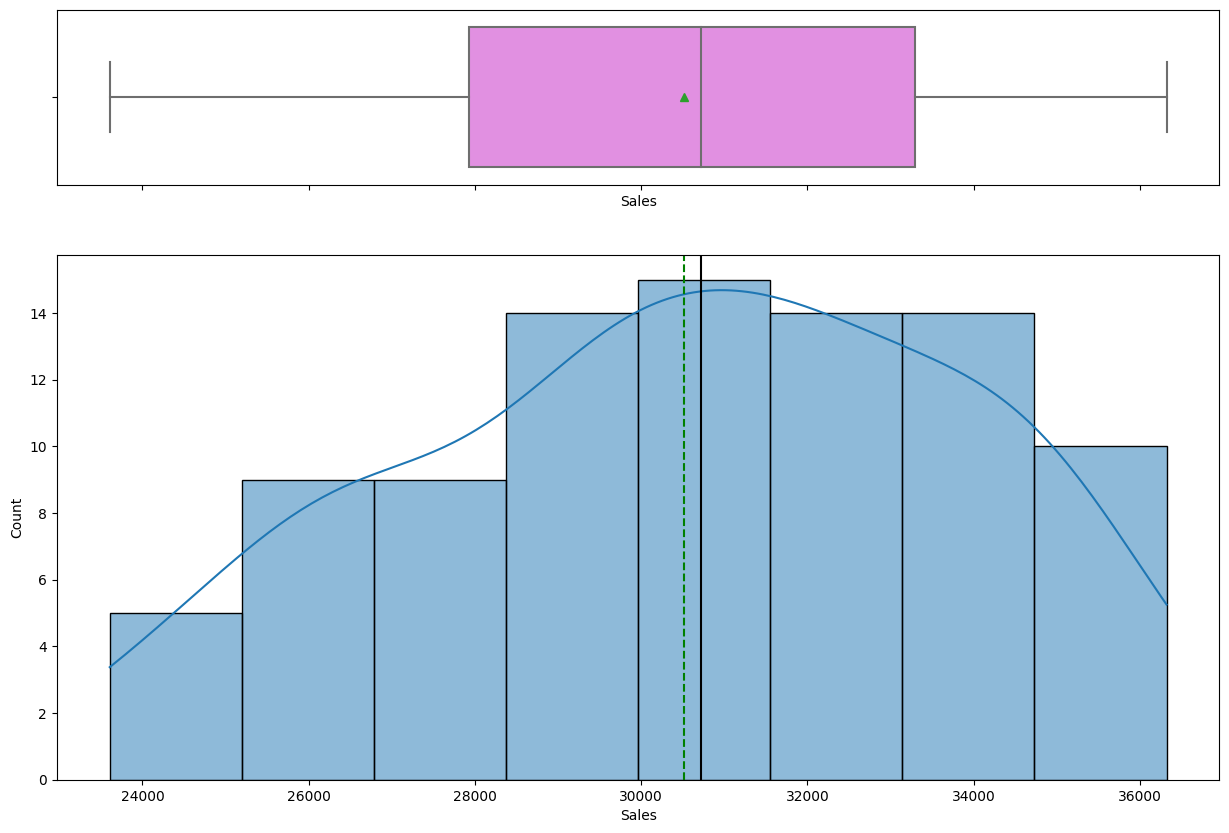

In [ ]:
histplot_boxplot(df1['Sales'])

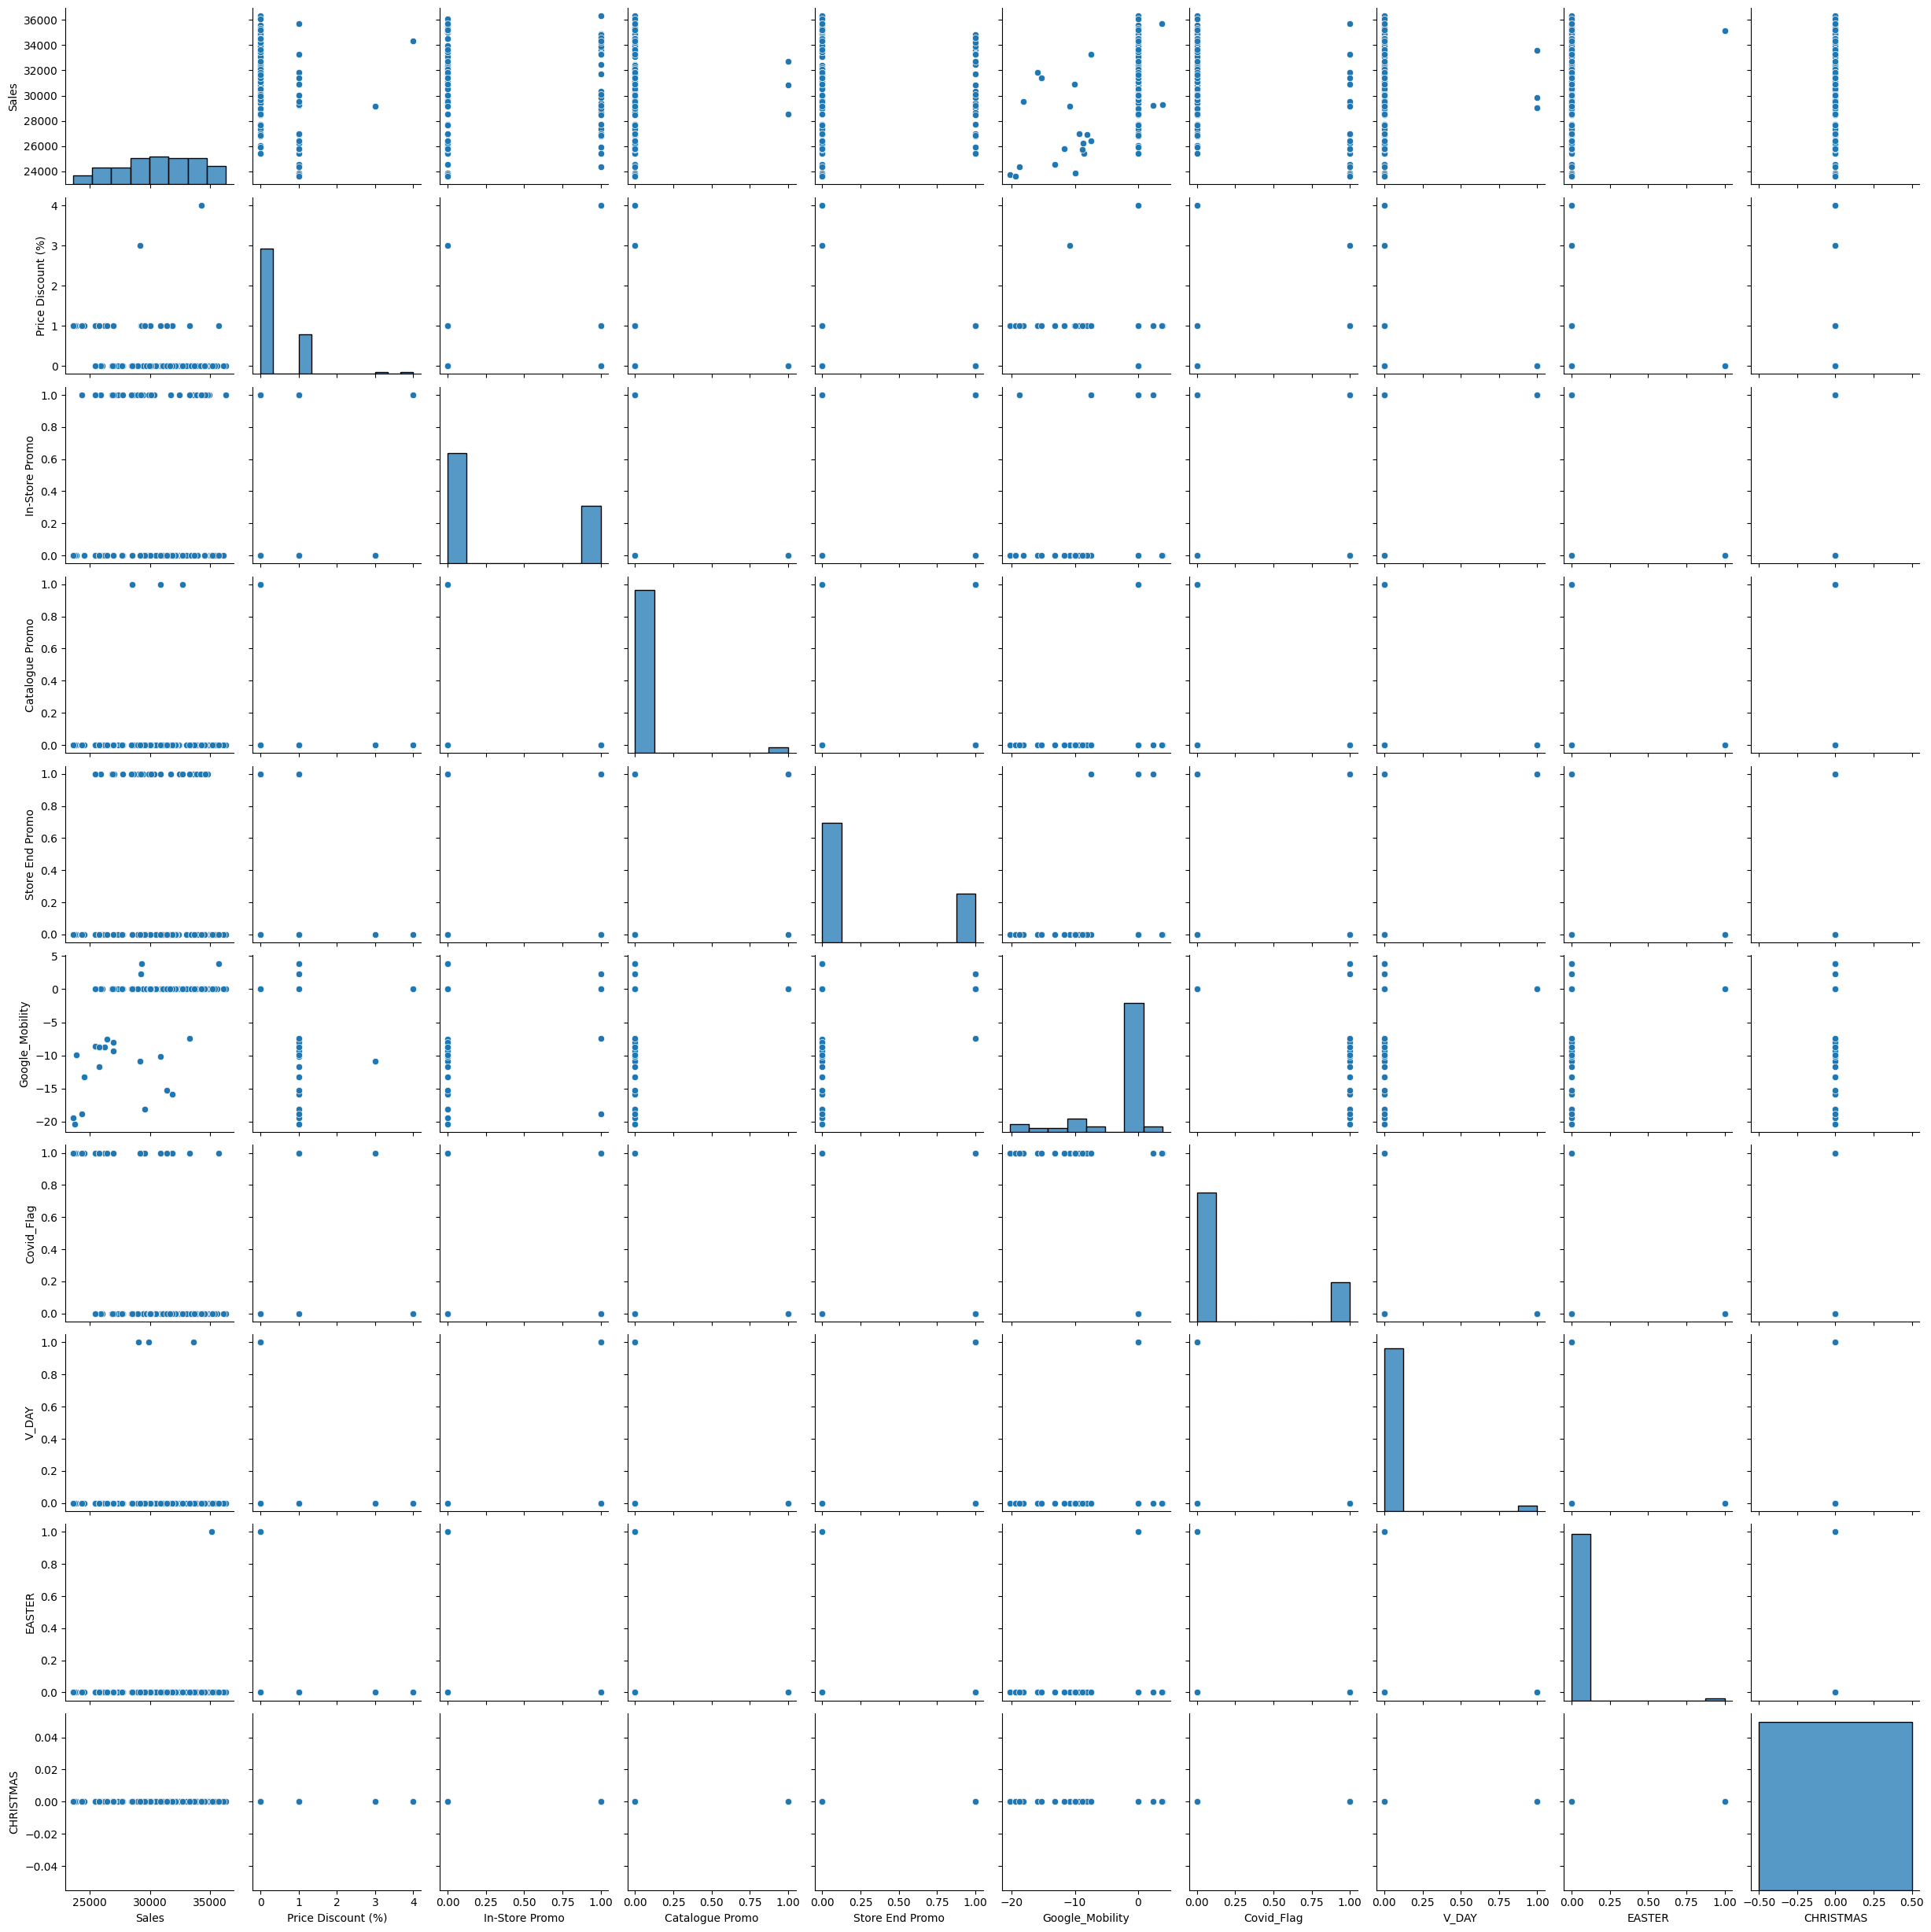

In [ ]:

sns.pairplot(data=df1.iloc[:, 1:])

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df1test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df1test[0])
     print("2. P-Value : ", df1test[1])
     print("3. Num Of Lags : ", df1test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df1test[3])
     print("5. Critical Values :")
     for key, val in df1test[4].items():
         print("\t",key, ": ", val)
adf_test(df1['Sales'])

1. ADF :  -3.233562395404913
2. P-Value :  0.0181223171307744
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 89
5. Critical Values :
	 1% :  -3.506057133647011
	 5% :  -2.8946066061911946
	 10% :  -2.5844100201994697


In [ ]:
df1["Sales"].astype(int)

0      27750
1      29023
3      26789
5      29731
6      27365
       ...  
183    24543
184    23744
185    23606
186    24346
195    33267
Name: Sales, Length: 90, dtype: int64

In [ ]:
df1.head()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,2017-02-05,27750,0,0,0,0,0.0,0,0,0,0
1,2017-02-12,29023,0,1,0,1,0.0,0,1,0,0
3,2017-02-26,26789,0,1,0,1,0.0,0,0,0,0
5,2017-03-12,29731,0,0,0,0,0.0,0,0,0,0
6,2017-03-19,27365,0,1,0,0,0.0,0,0,0,0


In [ ]:
df1['Sales'] = pd.to_numeric(df1['Sales'])
df1.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
el_df=df1.set_index('date')

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

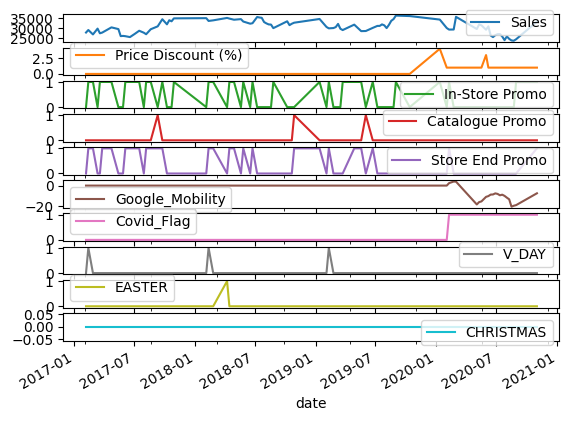

In [ ]:
el_df.plot(subplots=True)

In [ ]:
el_df.resample('M').mean()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
date,,,,,,,,,,
2017-02-28,27854.000000,0.0,0.666667,0.00,0.666667,0.000000,0.000000,0.333333,0.000000,0.0
2017-03-31,28272.666667,0.0,0.666667,0.00,0.333333,0.000000,0.000000,0.000000,0.000000,0.0
2017-04-30,30361.000000,0.0,1.000000,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-05-31,27157.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-06-30,25674.500000,0.0,1.000000,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-07-31,27769.333333,0.0,0.666667,0.00,0.666667,0.000000,0.000000,0.000000,0.000000,0.0
2017-08-31,28151.500000,0.0,1.000000,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-09-30,32677.500000,0.0,0.500000,0.50,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
2017-10-31,33553.000000,0.0,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
print ("\nMissing values :  ", df1.isnull().any())


Missing values :   date                  False
Sales                 False
Price Discount (%)    False
In-Store Promo        False
Catalogue Promo       False
Store End Promo       False
Google_Mobility       False
Covid_Flag            False
V_DAY                 False
EASTER                False
CHRISTMAS             False
dtype: bool


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

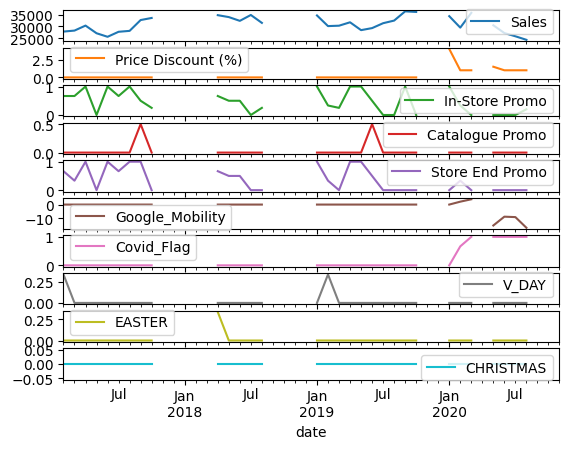

In [ ]:
el_df.resample('M').mean().plot(subplots=True)

In [ ]:
final_df=el_df.resample('M').mean()

In [ ]:
final_df.isnull().any()

Sales                 True
Price Discount (%)    True
In-Store Promo        True
Catalogue Promo       True
Store End Promo       True
Google_Mobility       True
Covid_Flag            True
V_DAY                 True
EASTER                True
CHRISTMAS             True
dtype: bool

In [ ]:
final_df1=final_df.dropna()

In [ ]:
final_df1.isna().sum()

Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [ ]:
import pmdarima as pm
model = pm.auto_arima(final_df1['Sales'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=627.085, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=630.683, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=630.693, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=625.196, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=629.034, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=629.042, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=628.724, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=628.731, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=630.504, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.840 seconds


In [ ]:
pip install pmdarima

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train['Sales'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1051.303, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1053.074, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1053.256, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1049.407, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1054.224, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.015 seconds


In [ ]:
train=df1.iloc[:-30]
test=df1.iloc[-30:]
train.head()


,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,2017-02-05,27750,0,0,0,0,0.0,0,0,0,0
1,2017-02-12,29023,0,1,0,1,0.0,0,1,0,0
3,2017-02-26,26789,0,1,0,1,0.0,0,0,0,0
5,2017-03-12,29731,0,0,0,0,0.0,0,0,0,0
6,2017-03-19,27365,0,1,0,0,0.0,0,0,0,0


In [ ]:

test.head()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
129,2019-07-28,31386,0,0,0,0,0.0,0,0,0,0
130,2019-08-04,29985,0,0,0,0,0.0,0,0,0,0
131,2019-08-11,31628,0,0,0,0,0.0,0,0,0,0
132,2019-08-18,33665,0,0,0,0,0.0,0,0,0,0
133,2019-08-25,34550,0,0,0,0,0.0,0,0,0,0


In [ ]:
train['Sales'] = pd.to_numeric(train['Sales'])
train.dtypes

<ipython-input-57-7946fbb2322f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sales'] = pd.to_numeric(train['Sales'])


date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [ ]:
import statsmodels.api as sm


In [ ]:
np.asarray(train)

array([[Timestamp('2017-02-05 00:00:00'), 27750, 0, 0, 0, 0, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-02-12 00:00:00'), 29023, 0, 1, 0, 1, 0.0, 0, 1,
        0, 0],
       [Timestamp('2017-02-26 00:00:00'), 26789, 0, 1, 0, 1, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-03-12 00:00:00'), 29731, 0, 0, 0, 0, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-03-19 00:00:00'), 27365, 0, 1, 0, 0, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-03-26 00:00:00'), 27722, 0, 1, 0, 1, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-04-23 00:00:00'), 30361, 0, 1, 0, 1, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-05-14 00:00:00'), 29490, 0, 0, 0, 0, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-05-21 00:00:00'), 25936, 0, 0, 0, 0, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-05-28 00:00:00'), 26045, 0, 0, 0, 0, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-06-04 00:00:00'), 25903, 0, 1, 0, 1, 0.0, 0, 0,
        0, 0],
       [Timestamp('2017-06-18 00:00:00'), 2

In [ ]:
test['Sales'] = pd.to_numeric(test['Sales'])

<ipython-input-60-946efaf77fa4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sales'] = pd.to_numeric(test['Sales'])


In [ ]:
#from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Sales'],order=(2,0,0))
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   60
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -528.604
Date:                Mon, 28 Aug 2023   AIC                           1065.209
Time:                        00:31:46   BIC                           1073.586
Sample:                             0   HQIC                          1068.486
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.107e+04   1211.790     25.639      0.000    2.87e+04    3.34e+04
ar.L1          0.6337      0.134      4.743      0.000       0.372       0.896
ar.L2          0.2111      0.136      1.548      0.122      -0.056       0.478
sigma2      2.599e+06   5.16e+05      5.036      0.000    1.59e+06    3.61e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.80   Prob(JB):                         0.90
Heteroskedasticity (H):               0.78   Skew:                             0.02
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

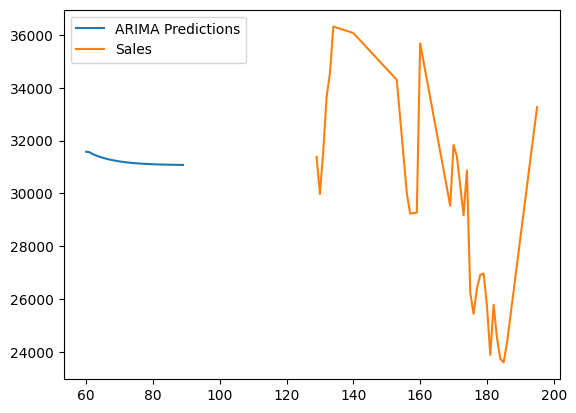

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Sales'].plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred,test['Sales']))
print(rmse)


4221.093933366003


In [ ]:
?ARIMA

**Observation**  
Sales has skewed to right. There are many outliers on left side. So, it is getting a long tail to left. To normalize, we put log there.  

In [ ]:
'''plt.figure(figsize=(10, 4))
sns.histplot(np.log(pandas_df['Sales']))
plt.xlabel("Log(Sales)")
plt.show()'''

In [ ]:
from pyspark.sql.functions import col, log

# We can Add a transformed New Sales feature in data
pandas_df['Sales_log'] = np.log(pandas_df['Sales'])

df = df.withColumn("Log_Sales", log(col("Sales")))

Price Discount (%) has also same isseue. We put log for normalize.

In [ ]:
# We can Add a transformed New Price Discount (%) feature in data
#pandas_df['Price_Discount_(%)_log'] = np.log(pandas_df['Price_Discount_(%)'])

**Observarion**  
Price_Discount_(%) has skewd to right. But no outliers.  
When applying the log transformation, if the value of the "Price_Discount_(%)_log" column is 0 or less, the log transformation cannot be performed.  
In Price_Discount_(%)_log, some of them are values with less than 0 when it is normalized. We don't add the log column for it with PySpark.  

In [ ]:
#cols_num= pandas_df.select_dtypes(['number']).columns

#for i in cols_num:
  #histplot_boxplot(pandas_df[i])

In [ ]:
from pyspark.sql.functions import min, max

min_date = df.select(min("date")).first()[0]
print("oldest date:", min_date)

max_date = df.select(max("date")).first()[0]
print("latest date:", max_date)

In [ ]:
from pyspark.sql.functions import year, month, avg, sum, round

In [ ]:
monthly_avg_sales = df.withColumn("total_sales", round(df["Sales"], 2))

df = df.withColumn("year", year(df["date"]))
df = df.withColumn("month", month(df["date"]))

monthly_avg_sales = df.groupBy("year", "month").agg(avg("Sales").alias("average_sales"))

monthly_avg_sales = monthly_avg_sales.orderBy("year", "month", descending=[False, False])

monthly_avg_sales.show()

In [ ]:
monthly_avg_sales.toPandas().plot();

In [ ]:
pandas_df = df.toPandas()

In [ ]:

sns.pairplot(pandas_df, diag_kind="kde")
plt.title("Pair Plot")
plt.show()

In [ ]:
sns.barplot(x='In-Store_Promo',y='Sales',data=pandas_df)

In [ ]:
sns.barplot(x='Catalogue_Promo',y='Sales',data=pandas_df)

In [ ]:
sns.barplot(x='Store_End_Promo',y='Sales',data=pandas_df)

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Google_Mobility',y='Sales',data=pandas_df)
plt.xticks(rotation=90)

In [ ]:
sns.barplot(x='Covid_Flag',y='Sales',data=pandas_df)

In [ ]:
sns.barplot(x='V_DAY',y='Sales',data=pandas_df)

In [ ]:
sns.barplot(x='CHRISTMAS',y='Sales',data=pandas_df)

**Observation**  
Variables below are already dummy varibles which we don't need to treat in terms of creation of dummy variable from One-hot encoding.   
-In-Store Promo   
-Catalogue Promo   
-Store End Promo   
-Covid_Flag   
-V_DAY   
-EASTER   
-CHRISTMAS  

In [ ]:
plt.figure(figsize=(20, 6))

sns.barplot(x='Price_Discount_(%)', y='Sales', data=pandas_df)

plt.title("Price Discount (%)")
plt.xlabel("Price Discount (%)")
plt.ylabel("Sales")
plt.xticks(rotation=90)

plt.show()

In [ ]:
plt.figure(figsize = (12, 7))

sns.heatmap(pandas_df.corr(), annot = True, vmin = -1, vmax = 1)

plt.title('Heat Map for Correlation')

plt.show()

In [ ]:
sns.barplot(x='year', y='Covid_Flag', data=pandas_df)

plt.title("Covid_Flag")
plt.xlabel("year")
plt.ylabel("Covid_Flag")
plt.xticks(rotation=90)

plt.show()

In [ ]:
window_spec = Window.orderBy("date")
df = df.withColumn("prev_flag", F.lag("Covid_Flag").over(window_spec))

start_dates = df.filter((F.col("Covid_Flag") == 1) & (F.col("prev_flag") == 0))

start_dates.select("Date").show()

**Observation**  
Covid Flag started from February 09, 2020.  

In [ ]:
pandas_df.head()

In [ ]:
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

yearly_profit = pandas_df.groupby([pandas_df['date'].dt.year, 'Product'])['Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_profit, x='date', y='Sales', hue='Product')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Yearly Sales by Product')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

In [ ]:

pandas_df['date'] = pd.to_datetime(pandas_df['date'])

monthly_profit = pandas_df.groupby([pandas_df['date'].dt.to_period('M'), 'Product'])['Sales'].sum().reset_index()
plt.figure(figsize=(20, 6))

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_profit, x='date', y='Sales', hue='Product')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales by Product')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


In [ ]:
! pip install plotly

In [ ]:
import plotly.express as px

pandas_df = df.toPandas()

fig = px.line(pandas_df, x='date', y='Google_Mobility', title='Google_Mobility')

fig.show()

**Observation**  
-Google Mobility is realted Covid19. This is because the line is flat until February 2, 2020 above the plot. The flat line means there are no activities and no exisiting record.   
-After February 9, 2020, it started fluctuating and keep changing. According to the variable Covid Flag, it started recorded as 1 after February 9, 2020. The timing between Google Mobility and Covid Flag is exactly coinside.  
-Google Mobility data tracks travel patterns in detail, such as how often people go to public places and how much time they spend commuting or shopping. This will allow us to assess the risk of spread of infection and predict the spread of infection in a particular region or city.  

In [ ]:
pandas_df = df.select('date', 'Google_Mobility').toPandas()

plt.figure()
plt.plot(pandas_df['date'], pandas_df['Google_Mobility'])
plt.xlabel('date')
plt.ylabel('Google_Mobility')
plt.title('Google_Mobility')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**To analyze the data pre-Covid and post-Covid, we divide the data to 2.**

In [ ]:
#spark = SparkSession.builder.appName("DatePartitioning").getOrCreate()

before_date = df.filter(col("date") < "2020-02-09")

after_date = df.filter(col("date") >= "2020-02-09")

before_date.show()
after_date.show()

In [ ]:
! pip install pyspark

In [ ]:
!pip install graphframes